# Tutorial 2.1: $V_{phys}$ Parametrization

In this section, we show how the $V_{phys}$ part of MB-nrg PEFs are parametrized. $V_{phys}$ is the underlying "physically-inspired" baseline consisting of dispersion and electrostatics interactions upon which the many-body polynomials are applied as "corrections". As a reminder, $V_{phys}$ has the form:

#### <center> $V_{phys} = V_{disp} + V_{elec}$ </center>

Here, $V_{disp}$ is the disperison energy and $V_{elec}$ is the electrostatics energy. $V_{disp}$ has the form:

#### <center> $V_{disp} = ...$ </center>

where, $R_{ij}$, $C^6_{ij}$, and $d^6_{ij}$ are the distance between atoms, dispersion coefficient, and damping parameter for atom pair $i$, $j$. $damp(...)$ is the tang-toennies damping function of the form:

#### <center> $damp(...) = ...$ </center>

And $V_{elec}$ has the form:

#### <center> $V_{elec} = ...$ </center>

where $q_i$, $p_i$, $\alpha_i$, and $\mu_i$ are the partial charge, polarizability, polarizability factor, and dipole moment at to site $i$.

Before we can build an MB-nrg PEF for any system, we first need to define the $q_i$, $p_i$, and $\alpha_i$ for each atom type and the $C^6_{ij}$ and $d^6_{ij}$ for each atom type pair.

<b>Note: This notebook describes how modern MB-nrg potentials are parametrized. Some models, such as MB-pol and older MB-nrg models were parametrized before the approach described here was standardized. Consult the publications about those PEFs for more details.</b>

That being said, we have found that MB-nrg PEFs are not too "sensitive" to the exact values of the parameters that enter $V_{phys}$, since the many-body PIPs will correct at short-range, and dispersion and electrostatics fall off *relatively* fast at long range. ("relatively" is doing a lot of work here.)

## 2.1.0 Definitions and Imports

In [48]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1.1 Polarizabilities and Polarizability Factors.

All MB-nrg models set the polarizability factors equal to the polarizabilities and calculate them in the following way:


#### <center> $p_i = \alpha_i = p^{free}_i  \frac{v_i}{v^{free}_i} ^ {4/3}$ </center>

Here, $p^{free}_i$, $v^{free}_i$, and $v_i$ are the free polarizability, free volume, and effective volume for atom $i$. We calculate the free volumes and effective volumes using QChem's implementation of the eXchange-hole Dipole Moment (XDM) model, and the free polarizabilities have been tabulated at the CCSD(T) level.

To run the XDM calculation, do the following:

In [23]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2 = read_system(definition_CH3NH2, paths.structures.minimized_CH3NH2)

In [13]:
polarizabilities_CH3NH2 = calculate_polarizabilities_by_XDM(
        minimized_structure_CH3NH2,
        f"{logs_dir}",
        paths.restart.polarizabilities_CH3NH2,
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(paths.jobs)
)

polarizability_factors_CH3NH2 = polarizabilities_CH3NH2

XDM calculation already completed... loading from restart file.


In [14]:
print(polarizabilities_CH3NH2)
print(polarizability_factors_CH3NH2)

{'A': 1.1961690533033624, 'B': 0.3322263799649547, 'C': 0.9504508010167653, 'D': 0.3532759027887244}
{'A': 1.1961690533033624, 'B': 0.3322263799649547, 'C': 0.9504508010167653, 'D': 0.3532759027887244}


Note that in addition to the "E" and "F" atoms (the "O" and "H" on water respectively. We also have "M" here. This corresponds to the M-site in MB-pol water. The polarizability of the M-site is 0, so that it does not have an induced dipole, but the polarizability factor is non-zero so that the charge at the M-site can still have its screening function computed.

In [22]:
polarizabilities_H2O = {
    "E": 1.310,
    "F": 0.294
}
polarizability_factors_H2O = {
    "E": 1.310,
    "F": 0.294
}

In [ ]:
write_parameters(paths.Vphys.polarizabilities, {**polarizabilities_CH3NH2, **polarizabilities_H2O})
write_parameters(paths.Vphys.polarizability_factors, {**polarizability_factors_CH3NH2, **polarizability_factors_H2O})

## 2.1.x Atomic Radii

In [27]:
radii_CH3NH2 = calculate_radii_by_XDM(
        minimized_structure_CH3NH2,
        f"{logs_dir}",
        paths.restart.radii_CH3NH2,
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(paths.jobs)
)

Beginning XDM calculation...
Completed XDM calculation!


In [28]:
radii_CH3NH2

{'A': 1.003204764154268,
 'B': 0.577466204832772,
 'C': 0.9575736540641085,
 'D': 0.586403492520731}

In [29]:
definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O = read_system(definition_H2O, paths.structures.minimized_H2O)

In [30]:
radii_H2O = calculate_radii_by_XDM(
        minimized_structure_H2O,
        f"{logs_dir}",
        paths.restart.radii_H2O,
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(jobs_dir)
)

Beginning XDM calculation...
Completed XDM calculation!


In [31]:
radii_H2O

{'E': 0.9183047911211052, 'F': 0.5857168367492249}

In [32]:
write_parameters(paths.Vphys.radii, {**radii_CH3NH2, **radii_H2O})

## 2.1.2 Atomic Partial Charges.

Previous MB-nrg models have used a variety of methods to calculate the atomic partial charges. MB-pol uses the Partridge-Swenkee (check sp lol) geometry-dependent atomic partial charges. Other models have used either Charge Model 5 (cite) or CHELPG (cite). The most recent generation of models has used charges fit to reproduce a monomer's multipole moments using an approach similar to the Stewart fitting appraoch (cite). However, we have recently developed a new apprach based on CHELPG that we feel provides the most useful model of a monomer's charge for our purposes. 

We will fit the partial charges of methylamine to reproduce the electrostatic potential on a number of grid points. However unlike CHELPG, which uses grid points very close to the monomer's electron density (usually within 4 A of the nucleii), we will fit to points quite far away from the electron density. The justification for this is that since we will have the many-body polynomials to correct at short-range, so it is most important that our electrostatics model reproduces long-range interactions. We will fit to grid points that are between 9 and 11 Å past the edge of the electron density of our monomer.

To do that, run the following:

In [38]:
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [39]:
vibrational_modes_CH3NH2 = calculate_vibrational_modes(
        minimized_structure_CH3NH2,
        calculator,
        get_qchem_job_manager(jobs_dir),
        paths.restart.vibrational_modes_CH3NH2,
        16,
        32000
)
write_vibrational_modes(paths.structures.vibrational_modes_CH3NH2, vibrational_modes_CH3NH2)

Calculating vibrational modes:  |====================================================================================================| - 1/1
Completed vibrational mode calculations!


In [40]:
configuration_generator = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
        classical=False,
        distribution="constant",
        temperature=1000
)
charge_parametrization_configurations_CH3NH2 = list(configuration_generator.generate_configurations(num_configs=10, seed=12345))
write_systems(paths.Vphys.charge_configs_CH3NH2, charge_parametrization_configurations_CH3NH2)

Will generate configurations at temperature 1000 K.
Temp Distribution: temp (au) = 0.00316683 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 10 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 10 configs.


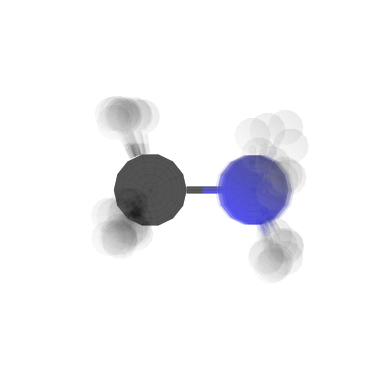

In [42]:
render_overlayed_systems(
    charge_parametrization_configurations_CH3NH2,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05
)

In [43]:
grid_points, grid_point_weights = get_ESP_grid_points(
        charge_parametrization_configurations_CH3NH2,
        atomic_radii=radii_CH3NH2,
        grid_radii=[9.0, 10.0, 11.0]
)

In [53]:
esp_at_grid_points = calculate_ESP_at_grid_points(
        charge_parametrization_configurations_CH3NH2,
        grid_points,
        esp_scratch_dir=paths.scratch.esp_CH3NH2,
        restart_path=calculate_ESP_at_grid_points,
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(paths.jobs)
)

Calculating ESP:  |====================================================================================================| - 10/10
Completed esp calculations!


In [57]:
charges_CH3NH2 = fit_charges_to_ESP(
        definition_CH3NH2,
        charge_parametrization_configurations_CH3NH2,
        grid_points=grid_points,
        grid_point_weights=grid_point_weights,
        grid_point_reference_values=esp_at_grid_points,
        formal_charge=0.0,
    
)

Charge fitting iteration: 12
Completed charge fitting!


In [58]:
charges_CH3NH2

{'A': 0.2626873982011333,
 'B': -0.023595293555435798,
 'C': -0.6608354614427159,
 'D': 0.234466971953945}

In [59]:
write_parameters(paths.Vphys.charges, charges_CH3NH2)

## 2.1.3 Dispersion Parameters

Lastly, we will calculate the dispersion coefficients ($C^6_{ij}$) and damping parameters ($d^6_{ij}$). These also both come from XDM, but in different ways. The $C^6$ are directly computed from XDM, by the equation:

#### <center> $C^6_{ij} = ... $ </center>

See QChem's documentation about the XDM module for more info (link).

The damping parameters are chosen so that the dispersion is exactly half on at a distance equal to the sum of the two atom's atomic radii ($r_i + r_j$). This is done by solving the following equation for $d_{ij}$:

#### <center> $ \frac{1}{2} = damp(r_i + r_j, d^6_{ij}) $ </center>

To run the XDM calculation and calculate the dispersion parameters, do the following:

In [71]:
C6_CH3NH2_H2O = calculate_C6_by_XDM(
        minimized_structure_CH3NH2,
        minimized_structure_H2O,
        paths.logs,
        paths.restart.dispersion_CH3NH2_H2O,
        method="wb97m-v",
        basis="aug-cc-pVTZ",
        num_threads=16,
        mem_mb=32000,
        job_manager=get_qchem_job_manager(paths.jobs)
)

XDM calculation already completed... loading from restart file.


In [72]:
C6_CH3NH2_H2O

{('A', 'E'): 215.65978868741462,
 ('A', 'F'): 103.08292627758921,
 ('B', 'E'): 81.55966323179395,
 ('B', 'F'): 37.424572619961545,
 ('C', 'E'): 200.9159401221131,
 ('C', 'F'): 92.4521980830751,
 ('D', 'E'): 82.35886249981964,
 ('D', 'F'): 38.01708242211851}

In [73]:
C6_H2O_H2O = {
    ("E", "E"): 2.373212214147944e+02,
    ("E", "F"): 8.349556669872743e+01,
    ("F", "F"): 2.009358600184719e+01,
}

In [74]:
write_parameters(paths.Vphys.C6, {**C6_CH3NH2_H2O, **C6_H2O_H2O})

In [75]:
d6_CH3NH2_H2O = calculate_d6_from_radii(
        radii1=radii_CH3NH2,
        radii2=radii_H2O,
        damping_at_radii_sum=0.5
)

In [76]:
d6_CH3NH2_H2O

{('A', 'E'): 3.47137451171875,
 ('A', 'F'): 4.19769287109375,
 ('B', 'E'): 4.4586181640625,
 ('B', 'F'): 5.7342529296875,
 ('C', 'E'): 3.5552978515625,
 ('C', 'F'): 4.3212890625,
 ('D', 'E'): 4.43267822265625,
 ('D', 'F'): 5.69000244140625}

In [77]:
d6_H2O_H2O = {
    ("E", "E"): 9.295485815062264e+00,
    ("E", "F"): 9.775202425217957e+00,
    ("F", "F"): 9.406475169954112e+00,
}

In [78]:
write_parameters(paths.Vphys.d6, {**d6_CH3NH2_H2O, **d6_H2O_H2O})

## 2.x.y Screening Parameters

In [79]:
aCC = 0.4

In [80]:
aCD = 0.4

In [81]:
aDD = 0.055
aDD14 = 0.055

all_symmetries = ["A", "B", "C", "D", "E", "F"]

aDD12 = {tuple(sorted([symmetry1, symmetry2])): 0.3 for symmetry1, symmetry2 in itertools.combinations_with_replacement(all_symmetries, r=2)}
aDD12[("E", "E")] = 0.626
aDD12[("E", "F")] = 0.626
aDD12[("F", "F")] = 0.626

aDD13 = {tuple(sorted([symmetry1, symmetry2])): 0.3 for symmetry1, symmetry2 in itertools.combinations_with_replacement(all_symmetries, r=2)}
aDD13[("E", "E")] = 0.055
aDD13[("E", "F")] = 0.055
aDD13[("F", "F")] = 0.055

## 2.1.4 Validation of $V_{phys}$ Parametrization

Great, we have our $V_{phys}$ parameters. To get a sense of the baseline we will add our many-body PIPs to, lets generate a few potential energy scans.

Since our monomers are small enough that everything is excluded, there is no $V_{phys}$ contribution at the 1-body level, so there is nothing interesting to see there. We will jump straight to the 2-body.

In [82]:
definition_CH3NH2_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O)

In [86]:
scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O, paths.scans.CH3NH2_H2O.first_energies)
scan_CH3NH2_H2O_1_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_energies)

scan_CH3NH2_H2O_1_Vphys_energies = calculate_Vphys_nmer_energies(
    definition_CH3NH2_H2O,
    scan_CH3NH2_H2O_1,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6=C6_CH3NH2_H2O,
    symmetries_to_d6=d6_CH3NH2_H2O,
    mbpol_monomers=[False, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_CH3NH2_H2O_1_Vphys_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_Vphys_energies)

/home/ebullvul/software/development/MB-Fit_versions/QDMS_2025/mbfit/potential/electrostatics.py:410: RuntimeWarning: invalid value encountered in double_scalars
  polarization_energy +=  (numpy.dot(numpy.array(dipole), numpy.array(dipole))) / symmetry_to_polarizability[atom.symmetry]


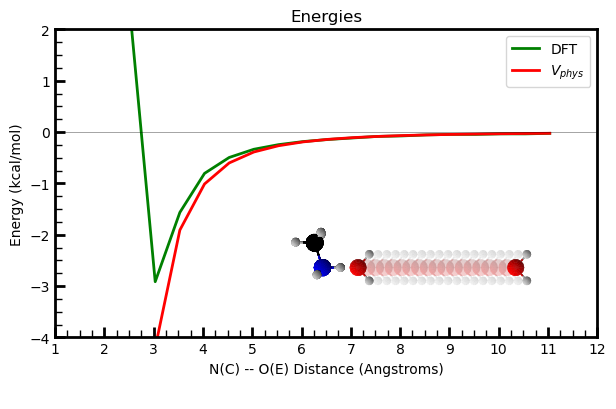

In [87]:
plot_scan(
        scan_CH3NH2_H2O_1,
        {
                "DFT": scan_CH3NH2_H2O_1_2b_energies,
                "$V_{phys}$": scan_CH3NH2_H2O_1_Vphys_2b_energies,
        },
        4,
        7,
        title="Energies",
        ymin=-4,
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
)

In [88]:
scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O, paths.scans.CH3NH2_H2O.second_energies)
scan_CH3NH2_H2O_2_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_energies)

scan_CH3NH2_H2O_2_Vphys_energies = calculate_Vphys_nmer_energies(
    definition_CH3NH2_H2O,
    scan_CH3NH2_H2O_2,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6=C6_CH3NH2_H2O,
    symmetries_to_d6=d6_CH3NH2_H2O,
    mbpol_monomers=[False, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_CH3NH2_H2O_2_Vphys_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_Vphys_energies)

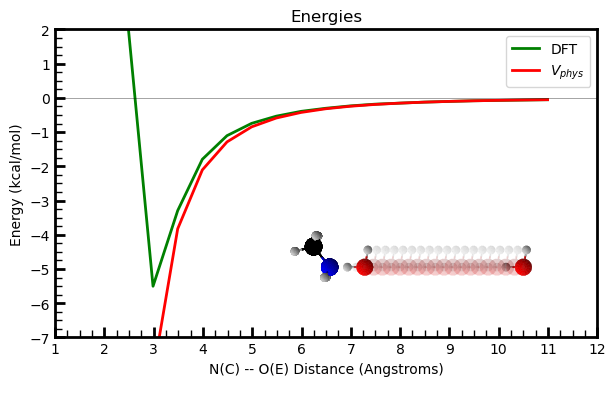

In [89]:
plot_scan(
        scan_CH3NH2_H2O_2,
        {
                "DFT": scan_CH3NH2_H2O_2_2b_energies,
                "$V_{phys}$": scan_CH3NH2_H2O_2_Vphys_2b_energies,
        },
        4,
        7,
        title="Energies",
        ymin=-7,
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
)

In [90]:
scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O, paths.scans.CH3NH2_H2O.third_energies)
scan_CH3NH2_H2O_3_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_energies)

scan_CH3NH2_H2O_3_Vphys_energies = calculate_Vphys_nmer_energies(
    definition_CH3NH2_H2O,
    scan_CH3NH2_H2O_3,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6=C6_CH3NH2_H2O,
    symmetries_to_d6=d6_CH3NH2_H2O,
    mbpol_monomers=[False, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_CH3NH2_H2O_3_Vphys_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_Vphys_energies)

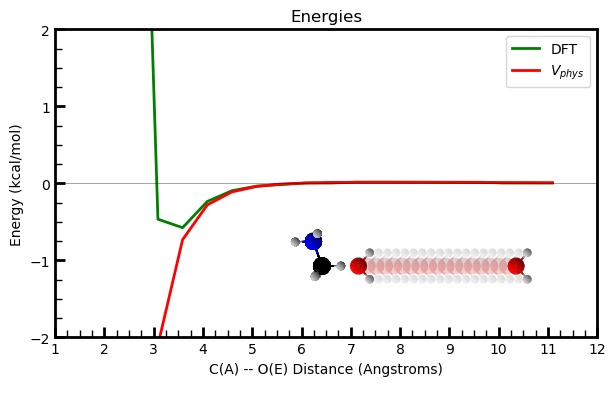

In [91]:
plot_scan(
        scan_CH3NH2_H2O_3,
        {
                "DFT": scan_CH3NH2_H2O_3_2b_energies,
                "$V_{phys}$": scan_CH3NH2_H2O_3_Vphys_2b_energies,
        },
        0,
        7,
        title="Energies",
        ymin=-2,
        ymax=2,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[4].point)
)

### 3B

In [92]:
definition_CH3NH2_H2O_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O_H2O)

In [44]:
scan_3b_1, scan_3b_1_energies = read_systems_and_nmer_energies(trimer_CH3NH2_H2O_H2O_definition_path, scan_3b_energies_1_path)
scan_3b_1_3body_energies = calculate_many_body_energies(scan_3b_1, scan_3b_1_energies)

scan_3b_1_Vphys_energies = calculate_Vphys_nmer_energies(
    read_definition(trimer_CH3NH2_H2O_H2O_definition_path),
    scan_3b_1,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6={**C6, **C6_water},
    symmetries_to_d6={**d6, **d6_water},
    mbpol_monomers=[False, True, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_3b_1_Vphys_3body_energies = calculate_many_body_energies(scan_3b_1, scan_3b_1_Vphys_energies)

In [93]:
scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies = read_systems_and_nmer_energies(definition_CH3NH2_H2O_H2O, paths.scans.CH3NH2_H2O_H2O.first_energies)
scan_CH3NH2_H2O_H2O_1_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies)

scan_CH3NH2_H2O_H2O_1_Vphys_energies = calculate_Vphys_nmer_energies(
    definition_CH3NH2_H2O_H2O,
    scan_CH3NH2_H2O_H2O_1,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6=C6_CH3NH2_H2O,
    symmetries_to_d6=d6_CH3NH2_H2O,
    mbpol_monomers=[False, True, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_CH3NH2_H2O_H2O_1_Vphys_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_Vphys_energies)

FileNotFoundError: [Errno 2] No such file or directory: 'Tutorial_2_workdir/scans/CH3NH2_H2O_H2O/first_energies.xyz'

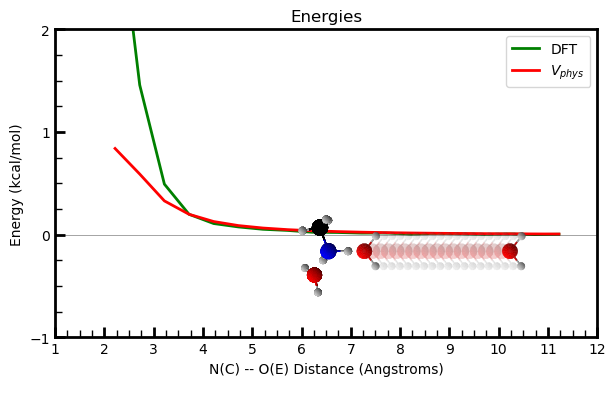

In [45]:
plot_scan(
        scan_3b_1,
        {
                "DFT": scan_3b_1_3body_energies,
                "$V_{phys}$": scan_3b_1_Vphys_3body_energies,
        },
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

In [47]:
scan_3b_2, scan_3b_2_energies = read_systems_and_nmer_energies(trimer_CH3NH2_H2O_H2O_definition_path, scan_3b_energies_2_path)
scan_3b_2_3body_energies = calculate_many_body_energies(scan_3b_2, scan_3b_2_energies)

scan_3b_2_Vphys_energies = calculate_Vphys_nmer_energies(
    read_definition(trimer_CH3NH2_H2O_H2O_definition_path),
    scan_3b_2,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6={**C6, **C6_water},
    symmetries_to_d6={**d6, **d6_water},
    mbpol_monomers=[False, True, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_3b_2_Vphys_3body_energies = calculate_many_body_energies(scan_3b_2, scan_3b_2_Vphys_energies)

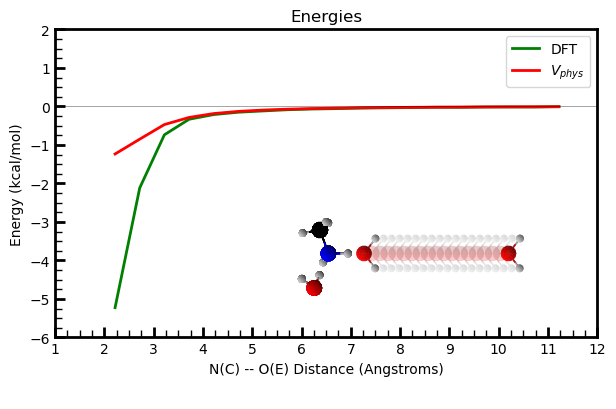

In [50]:
plot_scan(
        scan_3b_2,
        {
                "DFT": scan_3b_2_3body_energies,
                "$V_{phys}$": scan_3b_2_Vphys_3body_energies,
        },
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

In [51]:
scan_3b_3, scan_3b_3_energies = read_systems_and_nmer_energies(trimer_CH3NH2_H2O_H2O_definition_path, scan_3b_energies_3_path)
scan_3b_3_3body_energies = calculate_many_body_energies(scan_3b_3, scan_3b_3_energies)

scan_3b_3_Vphys_energies = calculate_Vphys_nmer_energies(
    read_definition(trimer_CH3NH2_H2O_H2O_definition_path),
    scan_3b_3,
    symmetry_to_charge=charges_CH3NH2,
    symmetry_to_polarizability={**polarizabilities_CH3NH2, **polarizabilities_H2O},
    symmetry_to_polarizability_factor={**polarizability_factors_CH3NH2, **polarizability_factors_H2O},
    symmetries_to_C6={**C6, **C6_water},
    symmetries_to_d6={**d6, **d6_water},
    mbpol_monomers=[False, True, True], # special flag to enable MB-pol geometry-dependent charges for the water molecule,
    aCC=aCC,
    aCD=aCD,
    aDD=aDD,
    aDD12=aDD12,
    aDD13=aDD13,
    aDD14=aDD14,
)

scan_3b_3_Vphys_3body_energies = calculate_many_body_energies(scan_3b_3, scan_3b_3_Vphys_energies)

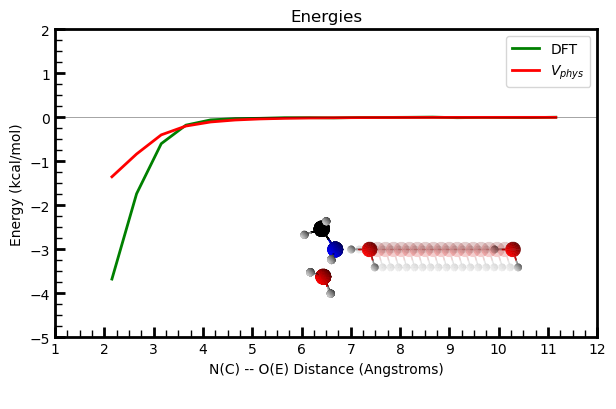

In [52]:
plot_scan(
        scan_3b_3,
        {
                "DFT": scan_3b_3_3body_energies,
                "$V_{phys}$": scan_3b_3_Vphys_3body_energies,
        },
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)